<a href="https://colab.research.google.com/github/mrfabien/MLEE_project/blob/main/MLEE_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setup

A few librairies are going to be used, so let's install them. For panda, you'll need to restart the kernel to update it, otherwise it won't work.

In [20]:
# Panda version needs to be higher than 1.4.1 to extract the data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import time
from sklearn.inspection import permutation_importance

# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

pd.__version__ 
%pip install pandas==1.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data preparation

Since the dataset is split into 2, one for moderate winds and the other dfor extreme winds. Let's merge them to simplify the notebook

In [21]:
# Path of the dataset

path_75 = 'df_europewinds_75.pkl'
path_95 = 'df_europewinds_95.pkl'

Let's look at the datasets

In [22]:
data_75 = pd.read_pickle(open(path_75, 'rb'))
data_75.head()

,year,index,bss0_1_mean,bss0_1_std,bss0_6_mean,bss0_6_std,rh1000_850_mean,rh1000_850_std,rh700_500_mean,rh700_500_std,...,lapse_s1_mean,lapse_s1_std,lapse700_500_mean,lapse700_500_std,total_totals_mean,total_totals_std,kindex_mean,kindex_std,cape_mean,cape_std
0,0,0,5.566746,1.409852,20.841965,2.403776,38.471111,5.528201,39.340164,4.507432,...,3.937160,1.835161,7.434533,0.157927,-223.870316,2.545162,-241.414597,1.920714,1.470943e+06,47421.042969
1,0,1,9.117043,2.212430,15.022616,1.769653,91.150574,4.519768,95.393280,3.446400,...,6.827473,0.361492,4.986881,0.123315,-230.567856,1.326195,-256.065704,2.432208,7.463997e+05,29720.560547
2,0,1,3.349157,1.543636,14.397669,1.997612,94.999939,3.762975,96.936325,2.179418,...,7.025648,0.705598,5.416773,0.279987,-229.407089,0.455871,-254.261292,0.960245,7.808471e+05,32203.679688
3,0,1,3.522637,1.343964,6.980061,1.558338,86.109894,6.356337,87.546326,8.126277,...,6.696632,0.315548,6.247573,0.096321,-225.117264,0.556208,-242.131607,0.737710,3.299286e+05,44017.738281
4,0,1,2.906259,1.306351,18.640661,0.778727,76.630363,11.766706,75.178864,5.603858,...,5.132456,0.965875,6.791603,0.163507,-221.258957,0.740583,-236.590332,0.754513,8.468746e+05,69275.562500


In [23]:
data_95 = pd.read_pickle(open(path_95, 'rb'))
data_95.head()

,year,index,bss0_1_mean,bss0_1_std,bss0_6_mean,bss0_6_std,rh1000_850_mean,rh1000_850_std,rh700_500_mean,rh700_500_std,...,lapse_s1_mean,lapse_s1_std,lapse700_500_mean,lapse700_500_std,total_totals_mean,total_totals_std,kindex_mean,kindex_std,cape_mean,cape_std
0,0,0,4.277383,1.872966,8.982351,0.724258,93.492226,5.035859,88.534180,5.347477,...,6.906764,1.327869,6.136250,0.066148,-229.698380,2.886750,-253.835098,3.049098,2.026168e+05,14708.218750
1,0,0,1.802277,0.753601,15.204497,0.530935,59.056320,1.762953,41.138809,20.166151,...,7.818282,0.271740,6.264568,0.162757,-229.545853,2.025261,-257.027924,5.805379,1.180107e+06,50493.390625
2,0,0,0.715803,0.243926,16.503664,0.667165,59.690506,3.856417,24.401155,8.628385,...,7.912159,0.212544,6.037870,0.176981,-230.075562,1.594442,-261.277252,2.990737,1.271284e+06,24269.503906
3,0,0,1.606050,1.158768,18.095135,1.584871,29.221788,1.806868,54.221584,3.082348,...,7.784466,0.688592,8.378917,0.154145,-220.908508,0.992791,-244.325333,1.691479,1.316592e+06,54253.433594
4,0,0,0.307757,0.309118,13.387435,1.153533,29.046917,3.302094,55.367680,3.316934,...,6.988350,0.134230,8.529189,0.123378,-221.513565,0.656967,-246.688919,0.659492,1.148537e+06,25503.769531


We need to create a new column to know whether or not it was a moderate wind or an extreme wind.

In [24]:
# Intensity 1 means extreme convective winds bursts and 0 means moderate convective bursts

data_75['intensity']=0
data_95['intensity']=1

In [25]:
# Merge the 2 dataset and separate the features from the intensity

data_merged = pd.concat((data_75,data_95))
y_all = data_merged['intensity']
X_all = data_merged.iloc[:,2:-1]

In [26]:
# Store the name of each predictor

features_names = data_merged.columns[2:-1]

# Data splitting

Two splitting of the dataset can be tested. One with train_test_split() and the other one with the 8 first years for the training, the next one for testing and the last one for validation.

In [27]:
# Splitting of the dataset with years

'''
years_training = np.arange(0,7)
years_test = np.arange(7,8)
years_valid = np.arange(8,9)

data_training = data_merged.loc[data_merged['year'].isin(years_training)]
data_test = data_merged.loc[data_merged['year'].isin(years_test)]
data_valid = data_merged.loc[data_merged['year'].isin(years_valid)]

X_train = data_training.iloc[:,2:-1]
y_train = data_training['intensity']
X_test = data_test.iloc[:,2:-1]
y_test = data_test['intensity']
X_valid = data_valid.iloc[:,2:-1]
y_valid = data_valid['intensity']
'''

"\nyears_training = np.arange(0,7)\nyears_test = np.arange(7,8)\nyears_valid = np.arange(8,9)\n\ndata_training = data_merged.loc[data_merged['year'].isin(years_training)]\ndata_test = data_merged.loc[data_merged['year'].isin(years_test)]\ndata_valid = data_merged.loc[data_merged['year'].isin(years_valid)]\n\nX_train = data_training.iloc[:,2:-1]\ny_train = data_training['intensity']\nX_test = data_test.iloc[:,2:-1]\ny_test = data_test['intensity']\nX_valid = data_valid.iloc[:,2:-1]\ny_valid = data_valid['intensity']\n"

In [28]:
# Splitting the dataset into a training (64%), testing (20%), and validation set (16%)

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_all, y_all, train_size=0.8)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, train_size=0.8)

# 1st algorithm : Logistic Regression


Let's try to predict the 2 classes of winds bursts with Logistic Regression on default settings

In [29]:
# Fitting the training set 

lr_default = LogisticRegression(random_state=42)
lr_default.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [30]:
# Prediction with the test set

prediction_lr_default = lr_default.predict(X_test)

lr_default_accuracy = accuracy_score(y_test, prediction_lr_default)

print(f"Logistic Regression model accuracy with default settings: {lr_default_accuracy:.2%}")

Logistic Regression model accuracy with default settings: 59.44%


The accuracy is ok, around 60%, so let's try to adujst the solver by picking another one.

In [31]:
# Fitting the training set with 'liblinear' solver. 
# The solver 'newton-cg' fits a little bit better, but the 4 solvers have roughly the same accuracy

lr_custom = LogisticRegression(solver='liblinear',
                                random_state=42)
lr_custom.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [32]:
# Let's try a prediction with the testing set

prediction_lr_custom = lr_custom.predict(X_train)
lr_custom_accuracy = accuracy_score(y_train, prediction_lr_custom)


print(f"Logistic Regression Model accuracy with costums settings on training set: {lr_custom_accuracy:.2%}")

Logistic Regression Model accuracy with costums settings on training set: 59.95%


The accuracy is marginally better, so let's try to see the accuracy on the testing set and the validation set.

In [33]:
# Prediction of the testing and validation set

y_pred_test_LR = lr_custom.predict(X_test)
y_pred_valid_LR = lr_custom.predict(X_valid)
print(f'Accuracy over training set: {(accuracy_score(y_test,y_pred_test_LR)):.2%} \n' 
f'Accuracy over test set: {(accuracy_score(y_valid,y_pred_valid_LR)):.2%}')

Accuracy over training set: 59.89% 
Accuracy over test set: 59.37%


The accuracy is still not good, just above 60%. The next step is to see the prediction with the confusion matrix on the testing set.

## Confusion Matrix on the testing set
This matrix allows to see : 

*   the the true positive (1,1)
*   the true negative (0,0)
*   the false negative (0,1)
*   the false positive (1,0)

In [34]:
# Confusion matrix on the testing set

cm = confusion_matrix(y_test, y_pred_test_LR, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

Result should look like the following image:

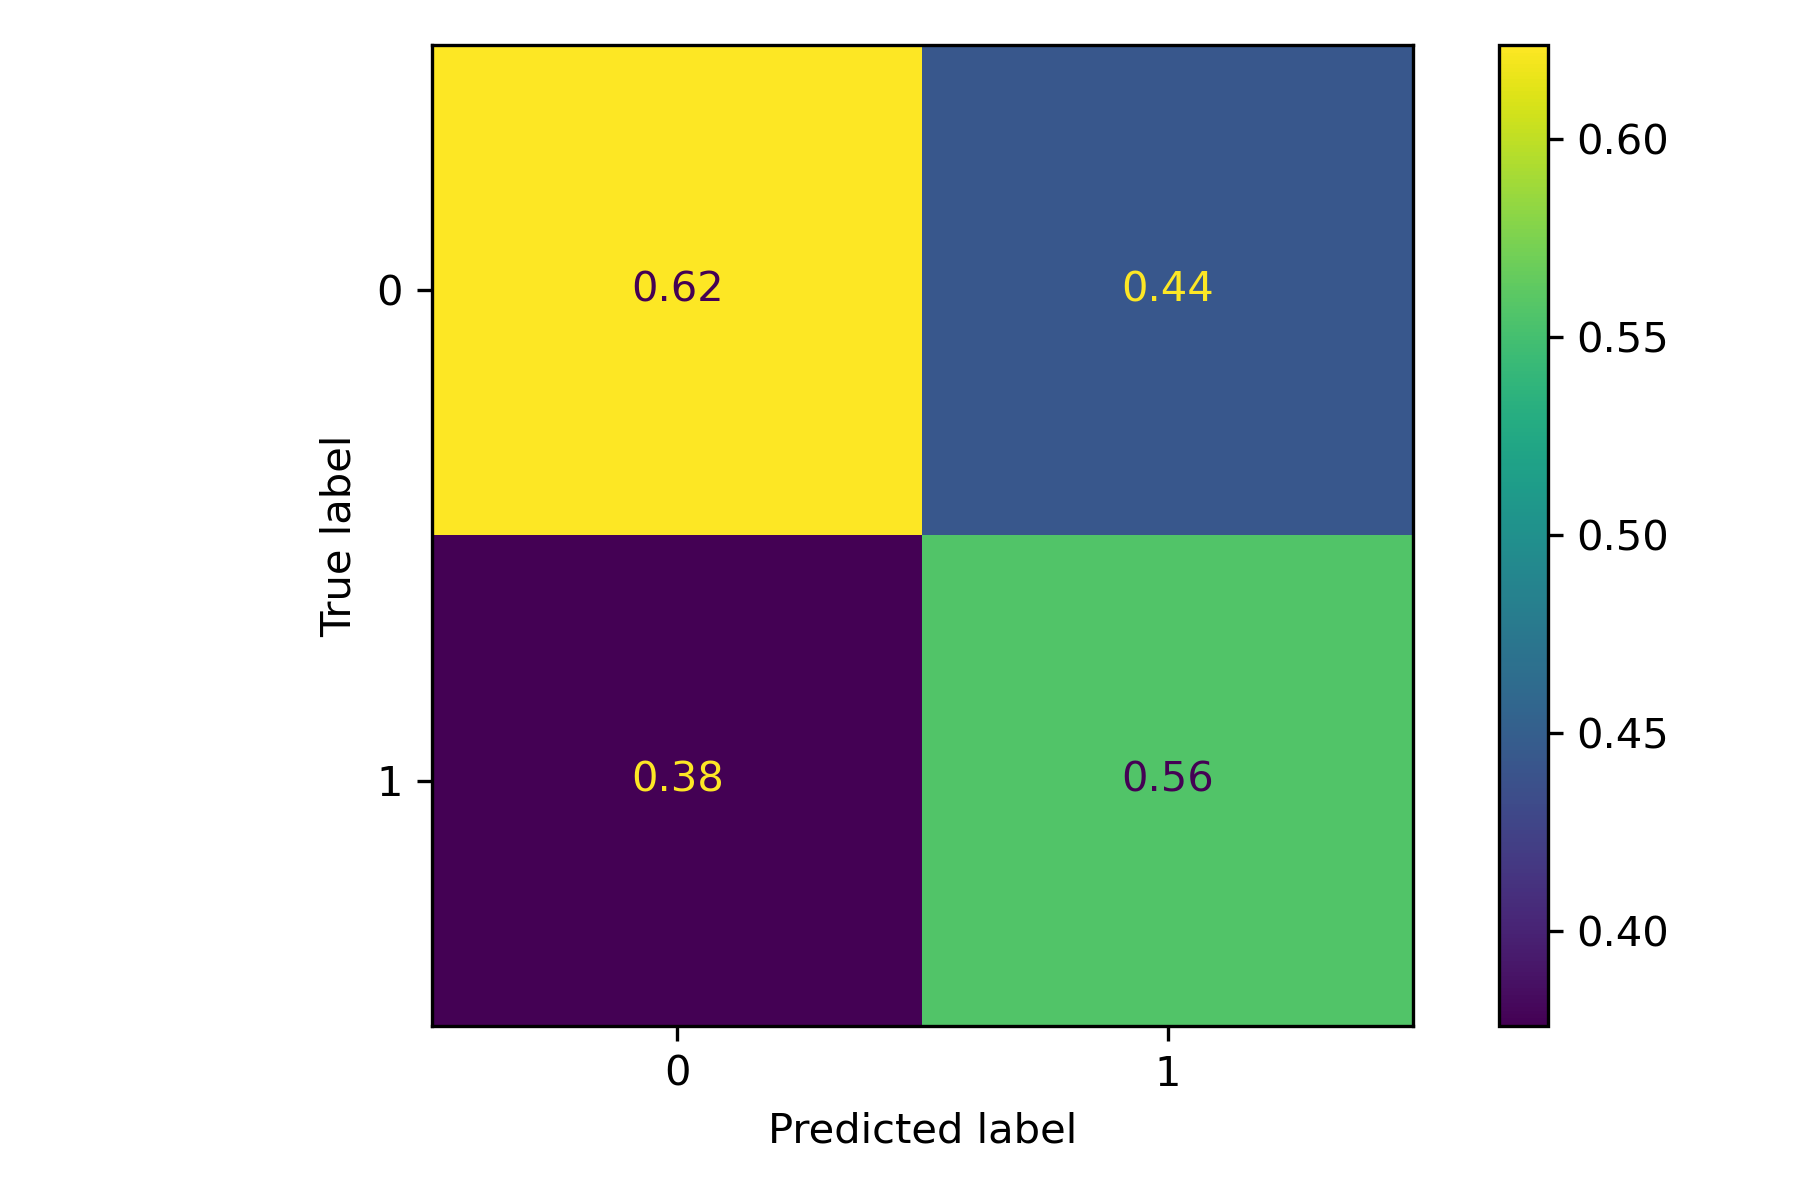

From this matrix, we can learn that the Logistic Regression predicts 44% with false positive and 38% with false negative. 

## Features permutation

The feature permutation gives an insight on which predictor is mainly used for the model. The following cell was copied from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html.


This cell mainly extract the importances of each feature and standardized them. It also check how much time it takes

Elapsed time to compute the importances: 5.330 seconds


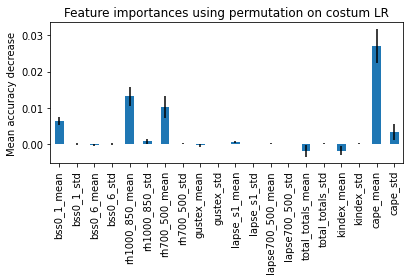

In [35]:
# Permutation of the features 

start_time = time.time()
result_LR = permutation_importance(
    lr_custom, X_test, y_test, n_repeats=20, random_state=42, n_jobs=6
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

logistic_importances = pd.Series(result_LR.importances_mean, index=features_names)

# Let's see the resutls. The higher the bar is, the more important the feature is

fig, ax = plt.subplots()
logistic_importances.plot.bar(yerr=result_LR.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on costum LR")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Logistic Regression doesn't really give strong results. Let's try Random Forest Classifier

# 2nd algorithm: Random Forest
Let's try to predict the 2 classes of winds bursts with Random Forest Classifier on default settings

In [36]:
# Fitting the training set 

rf_default = RandomForestClassifier(n_jobs = 6, random_state=42)
rf_default.fit(X_train,y_train)

RandomForestClassifier(n_jobs=6, random_state=42)

In [37]:
# Predictions of the testing set

prediction_rf_default = rf_default.predict(X_test)
rf_default_accuracy = accuracy_score(y_test, prediction_rf_default)

print(f"Random Forest model accuracy with default settings:: {rf_default_accuracy:.2%}")

Random Forest model accuracy with default settings:: 66.56%


Already, results are better than the Logistic Regression, but still under 70% of accuracy. Next step is to tune the hyperparameters

## Hyperparameters tuning

WARNING: this cell takes a long time to run (40 minutes). 4 different hyperparameters are tuned.

In [39]:
# param_grid helps to define the hyperparameters you would like to test, 
# and the ranges the hyperparameters should be in

param_grid = {'max_leaf_nodes':np.arange(60,220,20),
              'min_samples_split':np.arange(5,30,5),
              'n_estimators': np.arange(50, 300, 50),
              'max_depth': [3, 10, 20, 40]}

# Then, perform the HalvingGridSearch on the RandomForest

rf_custom = HalvingGridSearchCV(RandomForestClassifier(random_state=42),param_grid,cv=10,verbose=2, n_jobs=10, random_state=42)

# Next, try a new fit with the training set

start_time = time.time()
rf_custom.fit(X_train,y_train)
elapsed_time_RF = time.time() - start_time
print(f"Elapsed time to fit the training set with tuned hyperparameters Random Forest Classifier : {elapsed_time_RF:.3f} seconds")

n_iterations: 6
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 40
max_resources_: 23008
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 800
n_resources: 40
Fitting 10 folds for each of 800 candidates, totalling 8000 fits
----------
iter: 1
n_candidates: 267
n_resources: 120
Fitting 10 folds for each of 267 candidates, totalling 2670 fits
----------
iter: 2
n_candidates: 89
n_resources: 360
Fitting 10 folds for each of 89 candidates, totalling 890 fits
----------
iter: 3
n_candidates: 30
n_resources: 1080
Fitting 10 folds for each of 30 candidates, totalling 300 fits
----------
iter: 4
n_candidates: 10
n_resources: 3240
Fitting 10 folds for each of 10 candidates, totalling 100 fits
----------
iter: 5
n_candidates: 4
n_resources: 9720
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Elapsed time to fit the training set with tuned hyperparameters RF : 2308.182 seconds


In [41]:
# Best estimators are the following:

print('Best estimators are the following:',rf_custom.best_estimator_)

ls_be_RF = []
ls_be_RF = [rf_custom.best_params_['max_leaf_nodes'],
            rf_custom.best_params_['min_samples_split'],
            rf_custom.best_params_['n_estimators'],
            rf_custom.best_params_['max_depth']]

# Let's see the prediction from the tuned RF

prediction_rf_custom = rf_custom.predict(X_train)
rf_custom_accuracy = accuracy_score(y_train, prediction_rf_custom)

print(f"RF hyperparameters tuning Model Accuracy: {rf_custom_accuracy:.2%}")

# Now let's compare it with prediction based on the training and testing set

y_pred_test_RF = rf_custom.predict(X_test)
y_pred_valid_RF = rf_custom.predict(X_valid)
print(f'Accuracy over training set: {(accuracy_score(y_test,y_pred_test_RF)):.2%} \n' 
f'Accuracy over validation set: {(accuracy_score(y_valid,y_pred_valid_RF)):.2%}')

Best estimators are the following: RandomForestClassifier(max_depth=20, max_leaf_nodes=120, min_samples_split=15,
                       n_estimators=250, random_state=42)
RF hyperparameters tuning Model Accuracy: 71.81%
Accuracy over training set: 65.66% 
Accuracy over validation set: 65.37%


Results are barely better than the first try with RF, let's see the confusion matrix

## Confusion Matrix on testing test
This matrix allows to see : 

*   the the true positive (1,1)
*   the true negative (0,0)
*   the false negative (0,1)
*   the false positive (1,0)

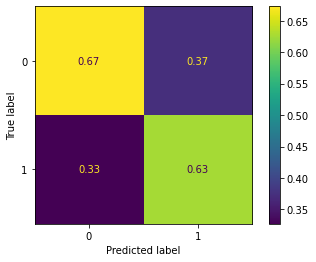

In [42]:
# Confusion matrix on the testing set


cm = confusion_matrix(y_test, y_pred_test_RF, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

In [ ]:
# Best estimators are the following:
selected_features = sfs.support_
selected_features  = np.array(X_train.columns)[np.array(selected_features)]
X_train_reduced = X_train[X_train.columns.intersection(selected_features)]
X_test_reduced = X_test[X_test.columns.intersection(selected_features)]


In [ ]:
rf3 = RandomForestClassifier(n_estimators=300)
rf3.fit(X_train_reduced,y_train)

RandomForestClassifier(n_estimators=300)

In [ ]:
# Let's see the prediction from the tuned RF

prediction_rf3 = rf3.predict(X_test_reduced)
sfs_accuracy = accuracy_score(y_test, prediction_rf3)

print(f"RF Model Accuracy: {sfs_accuracy:.2%}")

RF Model Accuracy: 60.88%


In [ ]:
# Now let's compare it with prediction based on the training and testing set

y_pred_train = rsc_rf.predict(X_train)
print(f'Accuracy over training set: {(accuracy_score(y_train,y_pred_train)):.2%} \n' 
f'Accuracy over test set: {(accuracy_score(y_test,prediction_rf3)):.2%}')

Accuracy over training set: 69.87% 
Accuracy over test set: 64.77%


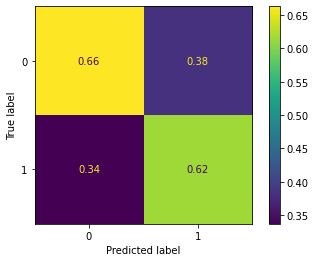

In [ ]:
# Results are barely better than the first try with RF, let's see the confusion matrix

cm = confusion_matrix(y_test, prediction_rf3, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

In [ ]:
# Since the performance are not clearly better than the LR, let's see what features are important for the RF
# The following cell was copied from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# This cell mainly extract the importances of each feature and standardized them
# It also check how much time it takes

import time

start_time = time.time()
importances = rf2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf2.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.087 seconds


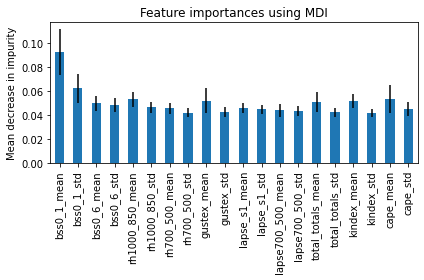

In [ ]:
# Let's see the features importance
# This cell was copied also from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

forest_importances = pd.Series(importances, index=features_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
# Let's try to permute the features and see how the model refit them
# Again, this was copied from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=features_names)

Elapsed time to compute the importances: 32.366 seconds


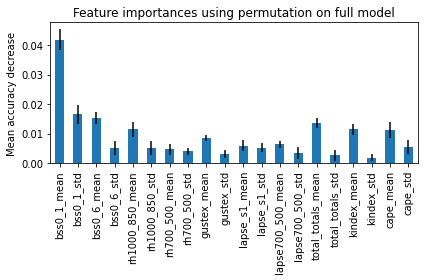

In [ ]:
# Let's see the results. The higher the bar is, the more important the feature is

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()